In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2
from source import run_e_step, run_EM, run_EM_with_restarts

# Постановка задачи

Пусть у нас есть изображения, на которых изображен статичный фон и объект. К сожалению, все полученные изображение слишком искажены и разобрать что на них изображено не получается. Мы рассмотрим следующий пример: ваша личная система видеонаблюдения заметила чье-то лицо на улице, тогда фон - улица, а объект - лицо человека.

### Мы будем считать известным следующие факты:

1) Фон изображения всегда один

2) Объект (лицо) это изображение фиксированного размера

3) После искажения к изображению добавили белый шум с заданной дисперсией


### Что не известно:

1) Какой именно фон

2) Какой именно объект (лицо)

3) Где находится объект (лицо)

### Цель:

1) Узнать что за объект

2) Востановить фон

3) Расшумить изображение

### Инструмент:

1) Байесовские методы

## Формализация

Дана выборка $\vec{X} = \{\vec{X}_k\}_{k=1}^K$ сильно зашумленных черно-белых изображений размера $H\times W$ пикселей. Каждое из этих изображений содержит один и тот же неподвижный фон и лицо в неизвестных координатах, при этом лицо попадает в любое изображение целиком. Будем считать, что изоражение лица имеет прямоугольную форму размера $h\times w$ пикселей. Значения $h,w$ заданы. Макет изображения показан на рисунке ниже.

<img src="./example.png" />

# Обозначения


$\vec{X}_k(i,j)$ - пиксель $k$-ого изображения;

$\vec{B}\in\mathbb{R}^{H\times W}$ - изображение чистого фона без лица, 
$\vec{B}(i,j)$ - пиксель этого изображения;

$\vec{F}\in\mathbb{R}^{h\times w}$ - изображение лица, $\vec{F}(i,j)$ - пиксель этого изображения;

$\vec{d}_k = (d^h_k,d^w_k)$ - координаты верхнего левого угла изображения лица на $k$-ом изображении ($d^h_k$ - по вертикали, $d^w_k$ - по горизонтали), $\vec{d} = (\vec{d}_1,\dots,\vec{d}_K)$ - набор координат для всех изображений выборки.

## Вероятностная модель

Также будем считать шум на изображении независимым для каждого пикселя и принадлежащим нормальному распределению $\mathcal{N}(0,s^2)$, где $s$ - стандартное отклонение. Таким образом для одного изображения имеем:

\begin{equation*}
    p(\vec{X}_k\mid \vec{d}_k, \vec{\theta})=\prod_{ij}
    \begin{cases} 
    	\mathcal{N}(\vec{X}_k(i,j)\mid \vec{F}(i-d_k^h,j-d_k^w),s^2), 
    	& \text{если } (i,j)\in faceArea(\vec{d}_k)\\
    	\mathcal{N}(\vec{X}_k(i,j)\mid \vec{B}(i,j),s^2), & \text{иначе}
    \end{cases},
\end{equation*}
где $\vec{\theta} = \{\vec{B},\vec{F},s^2\}$, $faceArea(\vec{d}_k) = \{(i,j)\mid d_k^h\leq i\leq d_k^h + h-1, d_k^w\leq j\leq d_k^w + w-1\}$


Распределение на неизвестные координаты лица на изображении зададим общим для всех изображений с помощью матрицы параметров $\vec{A}\in\mathbb{R}^{H-h+1,W-w+1}$ следующим образом:

\begin{equation*}
    p(\vec{d}_k\mid \vec{A})=\vec{A}(d_k^h,d_k^w),\quad\quad\quad   \sum_{ij}A(i,j) = 1,
\end{equation*}

где $\vec{A}(i,j)$ - элемент матрицы $\vec{A}$

В итоге имеем следующую совместную вероятностную модель:

\begin{equation*}
    p(\vec{X},\vec{d}\mid \vec{\theta},\vec{A}) = \prod_k 
    p(\vec{X}_k\mid \vec{d}_k,\vec{\theta})p(\vec{d}_k\mid\vec{A}).
\end{equation*}

# Данные

In [2]:
# Если SHOW_IMG = 0, то пока нельзя смотреть на данные

SHOW_IMG = 0

In [3]:
def show_img(img, title="", ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    
    ax.set_title(title)
    ax.imshow(img)
    
    ax.axis('off')
    plt.tight_layout()

Считаем лицо

In [18]:
F = np.load("./my_F.npy")
F = F[:, 3:-3]

h, w = F.shape

print(f"Размеры изображения лица: {F.shape}")


Размеры изображения лица: (42, 36)


Считаем изображение фона

In [19]:
B = np.load("./my_B.npy")

In [20]:
def get_dataset(s, K, B=B, F=F, seed=42):

    H, W = B.shape
    h, w = F.shape

    np.random.seed(seed)
    X = np.zeros((H, W, K))
    X_clear = np.zeros((H, W, K))
    
    coords = []
    for k in range(K):
        x = np.random.randint(0, H-h+1)
        y = np.random.randint(0, W-w+1)
        coords.append((x, y))
        
        X_clear[:, :, k] = np.copy(B)
        X_clear[x:x+h, y:y+w, k] = F
        X[:, :, k] = X_clear[:, :, k] + np.random.randn(H, W) * s 
    
    X = np.clip(X, 0, 255)
    return X_clear, X, coords

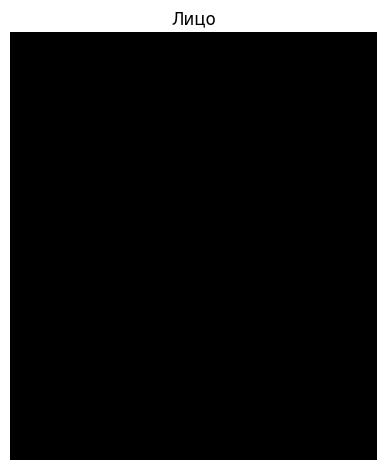

In [21]:
show_img(F * SHOW_IMG, "Лицо")

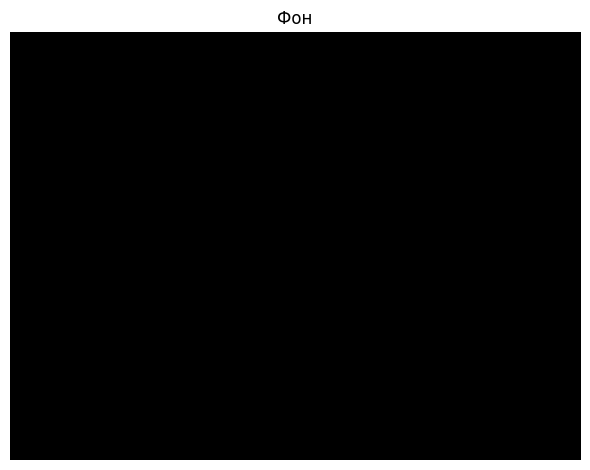

In [22]:
show_img(B * SHOW_IMG, "Фон") 

In [23]:
X_clear, X, coords = get_dataset(s=300, K=500)

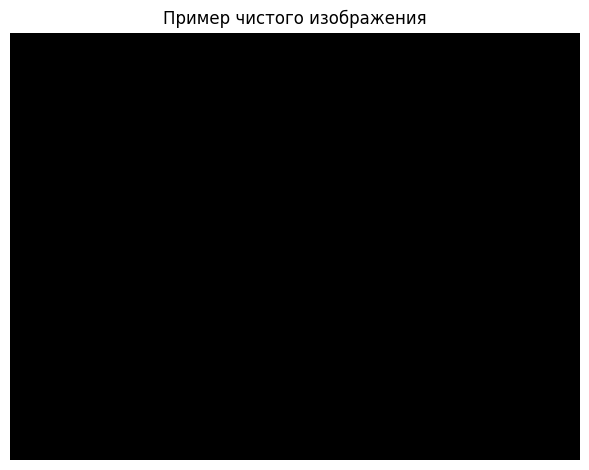

In [24]:
show_img(X_clear[:, :, 0] * SHOW_IMG, title="Пример чистого изображения")

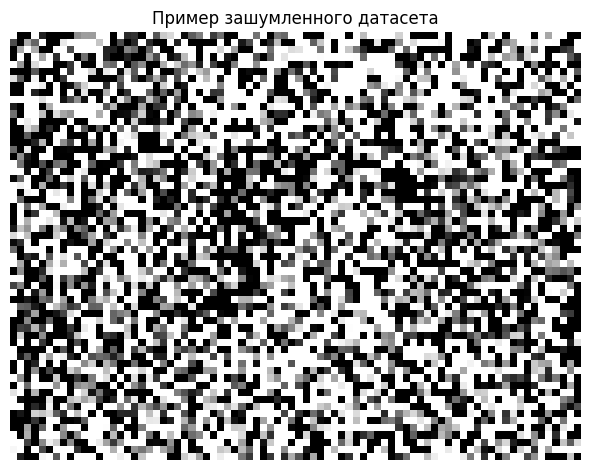

In [25]:
show_img(X[:, :, 0], title="Пример зашумленного датасета")

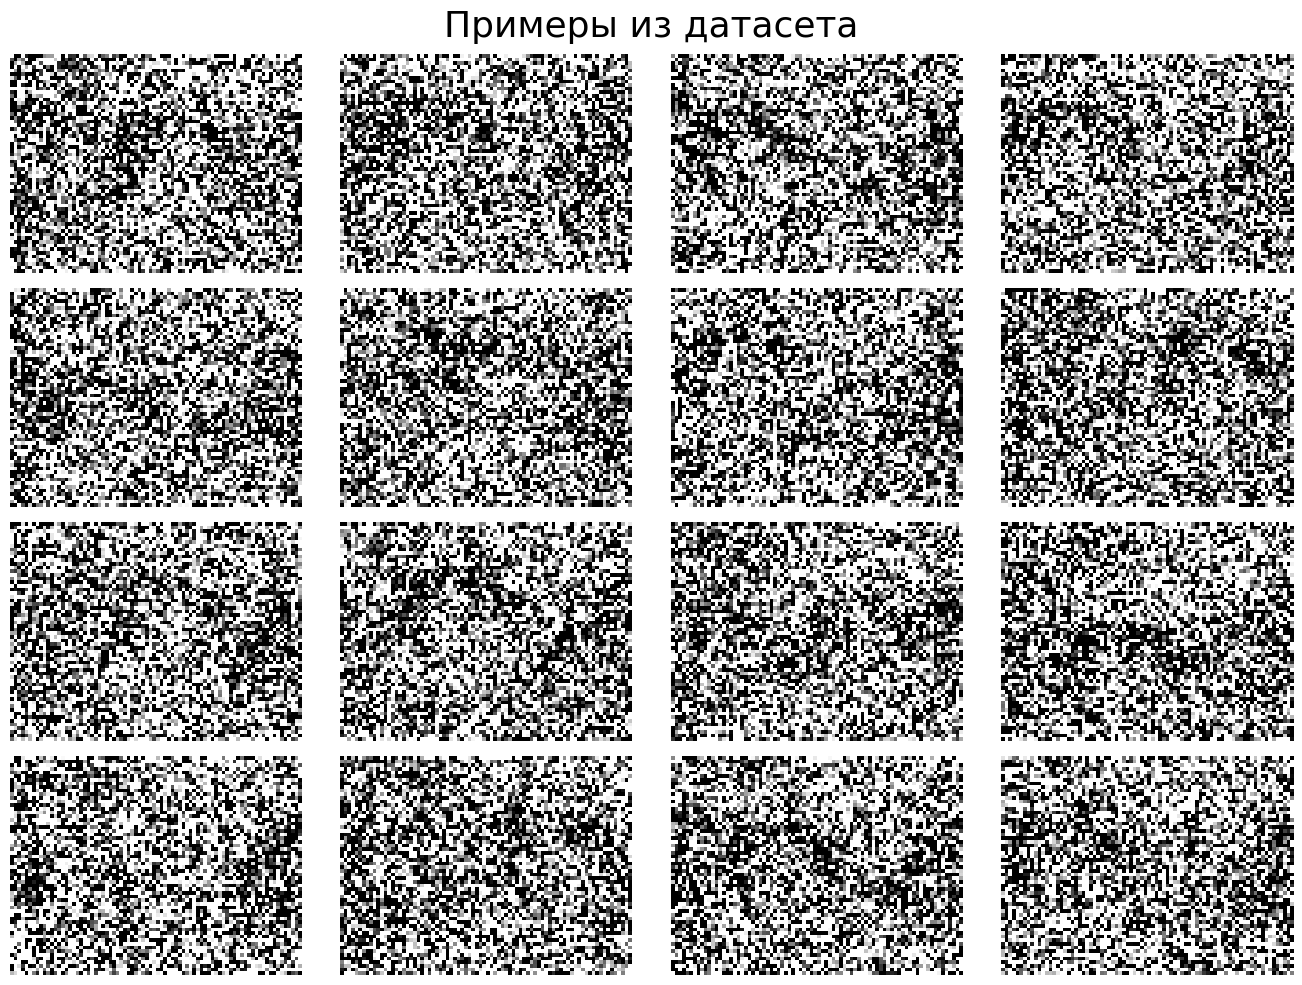

In [26]:
fig, ax = plt.subplots(4, 4, figsize=(14, 10))

fig.suptitle("Примеры из датасета", fontsize=26)
for i in range(16):
    
    show_img(X[:, :, i], ax=ax[i // 4, i % 4])
    
plt.tight_layout()

In [27]:
def show_data(F, B, X_clear, result, res_title="Зашумленное изображение"):
    
    fig, ax = plt.subplots(1, 4, figsize=(14, 4))



    ax[0].imshow(F * SHOW_IMG)
    ax[0].set_title("Лицо", fontsize=18)

    ax[1].imshow(B * SHOW_IMG)
    ax[1].set_title("Фон", fontsize=18)

    ax[2].imshow(X_clear[:, :, 0] * SHOW_IMG)
    ax[2].set_title("Исходное изображение", fontsize=18)

    ax[3].imshow(result)
    ax[3].set_title(res_title, fontsize=18)

    for a in ax:
        a.set_xticks([])
        a.set_yticks([])

    fig.tight_layout()
    plt.show()

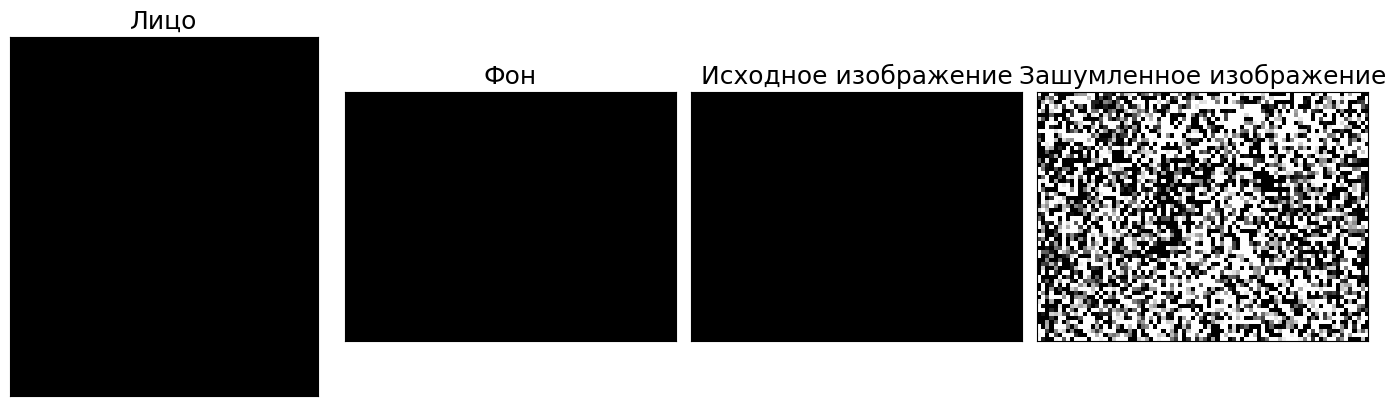

In [28]:
show_data(F, B, X_clear, X[:, :, 0])

In [29]:
F_new, B_new, s_new, A_new, losses = run_EM(X, h, w, tolerance=1e-6)

 62%|████████████████████████████████▊                    | 31/50 [00:31<00:19,  1.02s/it]


In [30]:
pos = run_e_step(X=X[:, :, :1], F=F_new, B=B_new, s=s_new, A=A_new, use_MAP=True)
x, y = pos[:, 0]

In [ ]:
result = np.copy(B_new)
result[x:x + h, y:y + w] = np.copy(F_new)


show_img(X_clear[:, :, 0], title="Исходное изображение")

show_img(result, title="Результат работы алгоритма")



In [ ]:
show_data(F_new, B_new, X_clear, result=result, res_title="Выход алгоритма")

# Эксперимент с рестартами

In [ ]:
F_new, B_new, s_new, A_new, results = run_EM_with_restarts(X=X, h=h, w=w, n_restarts=10, max_iter=50)

In [ ]:
for losses in results:
    plt.plot(losses, color='r', alpha=0.2)

plt.title("Значение нижней оценки по итерациям", fontsize=20)
plt.ylabel(r"$\mathcal{L}(q, \theta, A)$", fontsize=18)
plt.xlabel("Номер итерации", fontsize=18)
plt.grid()

plt.show()

# Эксперимент сравнение EM и hard EM

In [ ]:
X_clear, X, coords = get_dataset(s=200, K=2000)
F_new, B_new, s_new, A_new, losses = run_EM(X, h, w, use_MAP=True)

In [ ]:
show_img(F_new, title="Пример работы hard-EM")

plt.show()

In [ ]:
s = 200

results_exp3 = {"EM": {}, "HARD_EM": {}}

for k in K_grid:
    
    X_clear, X, coords = get_dataset(s=s, K=k)
    
    time_s = time.time()
    F_new, B_new, s_new, A_new, losses = run_EM_with_restarts(X, h, w, n_restarts=5, use_MAP=False)
    t = time.time() - time_s
    
    results_exp3["EM"][k] = {"time": t,
                            "F": F_new, 
                            "B": B_new,
                            "loss": losses, 
                            "X_clear": X_clear[:, :, 0],
                            "coords": coords[0],
                            "X": X[:, :, 0]
                            }
    
    time_s = time.time()
    F_new, B_new, s_new, A_new, losses = run_EM_with_restarts(X, h, w, n_restarts=5, use_MAP=True)
    t = time.time() - time_s
    
    results_exp3["HARD_EM"][k] = {"time": t,
                                "F": F_new, 
                                "B": B_new,
                                "loss": losses, 
                                "X_clear": X_clear[:, :, 0],
                                "coords": coords[0],
                                "X": X[:, :, 0]
                                }

In [ ]:
def show_images_exp3(value):
    fig, ax = plt.subplots(2, len(K_grid), figsize=(14, 4))

    for i, k in enumerate(K_grid):
        result = results_exp3["EM"][k]
        ax[0, i].imshow(result[value])
        ax[0, i].set_xticks([])
        ax[0, i].set_yticks([])

        result = results_exp3["HARD_EM"][k]
        ax[1, i].imshow(result[value])
        ax[1, i].set_xticks([])
        ax[1, i].set_yticks([])
    
    
    cols = [r'K = {}'.format(col) for col in K_grid]
    rows = ["EM", "hard EM"]

    for a, col in zip(ax[0], cols):
        a.set_title(col, fontsize=16)

    for a, row in zip(ax[:, 0], rows):
        a.set_ylabel(row, fontsize=16)
        
    fig.tight_layout()
    fig.suptitle(fr"Зависимость {value} от алгоритма", fontsize=22)
    fig.tight_layout()
    plt.savefig(f"{value}_exp3.svg")
    plt.show()
    

In [ ]:
show_images_exp3("F")

In [ ]:
show_images_exp3("B")

In [ ]:
times_hard = []
times_standard = []

for k in K_grid:
    times_hard.append(results_exp3["HARD_EM"][k]["time"])
    times_standard.append(results_exp3["EM"][k]["time"])

In [ ]:
plt.plot(K_grid, times_standard, label="EM")
plt.plot(K_grid, times_hard, label="hard EM")


plt.ylabel("Время, с.")
plt.xlabel("K - размерность выборки")
plt.legend()
plt.grid()
plt.title("Зависимость времени работы от алгоритма")

plt.show()